# Imports

In [1]:
! pip install transformers datasets
! pip install openpyxl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


In [2]:
import os
import logging
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import re
from datasets import Dataset

In [3]:
MAX_INPUT_LENGTH = 60
MIN_TARGET_LENGTH = 5
MAX_TARGET_LENGTH = 11
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
MAX_EPOCHS = 5
MODEL_CHECKPOINT = "t5-small"
prefix = "summarize: "

# Data Downloading

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d shashichander009/inshorts-news-data
! unzip "/content/inshorts-news-data.zip" -d "/content/dataset/"

 88% 11.0M/12.6M [00:01<00:00, 12.6MB/s]
100% 12.6M/12.6M [00:01<00:00, 7.73MB/s]
Archive:  /content/inshorts-news-data.zip
  inflating: /content/dataset/Inshorts Cleaned Data.xlsx  


# Data Loading

In [5]:
df = pd.read_excel("/content/dataset/Inshorts Cleaned Data.xlsx",engine = 'openpyxl')
df.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
df.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [6]:
df['Short'][0]

'The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.'

In [7]:
df.duplicated().sum()

106

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.isnull().sum()

Headline    0
Short       0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54998 entries, 0 to 55103
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  54998 non-null  object
 1   Short     54998 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [12]:
def standardization(input_data):
  input_data = str(input_data)
  no_tag = re.sub(r'<.*?>', '', input_data)
  no_url = re.sub(r'https?://\S+|www\.\S+', '', no_tag)
  return no_url

In [13]:
df['Short'] = df['Short'].apply(standardization)
df['Headline'] = df['Headline'].apply(standardization)

In [14]:
article_sequence_len = [len(sentence.split()) for sentence in df['Short']]
avg_article_sequence_len = np.mean(article_sequence_len)
summary_sequence_len = [len(sentence.split()) for sentence in df['Headline']]
avg_summary_sequence_len = np.mean(summary_sequence_len)

print("Avg Article Sequence Length:", avg_article_sequence_len)
print("Avg Summary Sequence Length:", avg_summary_sequence_len)

Avg Article Sequence Length: 58.18040656023855
Avg Summary Sequence Length: 8.255445652569184


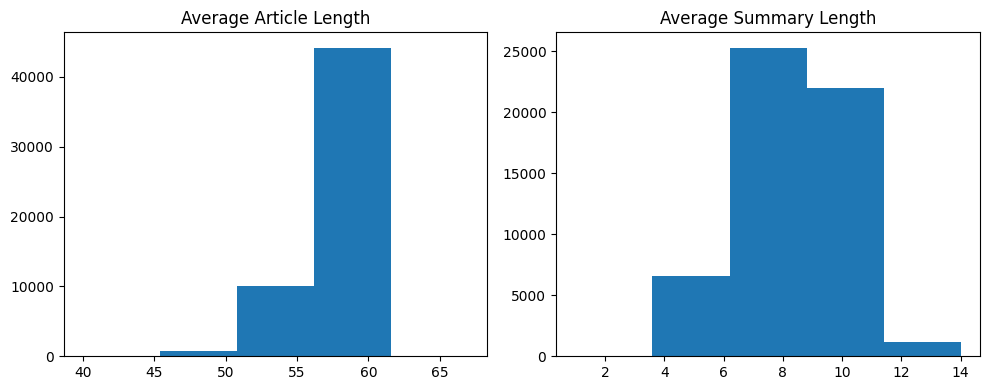

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Average Article Length")
plt.hist(article_sequence_len, bins=5)

plt.subplot(1, 2, 2)
plt.title("Average Summary Length")
plt.hist(summary_sequence_len, bins=5)

plt.tight_layout()
plt.show()

In [16]:
output_article_sequence_len = int(np.percentile(article_sequence_len, 95))
output_summary_sequence_len = int(np.percentile(summary_sequence_len, 95))
print("Output Article Sequence Length:", output_article_sequence_len)
print("Output summary Sequence Length:", output_summary_sequence_len)

Output Article Sequence Length: 60
Output summary Sequence Length: 11


In [17]:
dataset = Dataset.from_pandas(df)

In [18]:
print(dataset)

Dataset({
    features: ['Headline', 'Short', '__index_level_0__'],
    num_rows: 54998
})


In [19]:
print(dataset[0])

{'Headline': '4 ex-bank officials booked for cheating bank of ₹209 crore', 'Short': 'The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.', '__index_level_0__': 0}


In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [21]:
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["Short"]]
    model_inputs = tokenizer(inputs, max_length=60, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["Headline"], max_length=12, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [22]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/54998 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [23]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [24]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [25]:
dataset = tokenized_datasets.to_tf_dataset(
    batch_size=BATCH_SIZE,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [26]:
total_samples = len(dataset)

train_samples = int(0.8 * total_samples)
val_samples = total_samples - train_samples

tf_train_dataset = dataset.take(train_samples)
tf_val_dataset = dataset.skip(train_samples)

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer)

In [28]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=5)

Epoch 1/5
5500/5500 [==============================] - 645s 109ms/step - loss: 2.2412 - val_loss: 1.7102
Epoch 2/5
5500/5500 [==============================] - 586s 107ms/step - loss: 1.8711 - val_loss: 1.5629
Epoch 3/5
5500/5500 [==============================] - 585s 106ms/step - loss: 1.7493 - val_loss: 1.4707
Epoch 4/5
5500/5500 [==============================] - 588s 107ms/step - loss: 1.6688 - val_loss: 1.3819
Epoch 5/5
5500/5500 [==============================] - 643s 117ms/step - loss: 1.6109 - val_loss: 1.3430


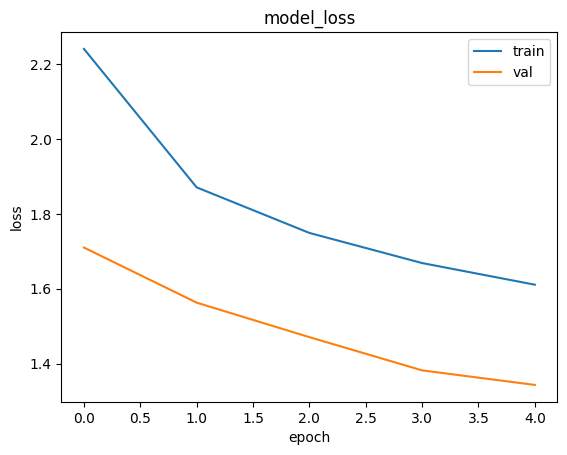

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# Model Evaluation

In [ ]:
! pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
import sacrebleu

all_preds = []
all_labels = []

for batch in tf_val_dataset.take(10):
    predictions = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

bleu_score = sacrebleu.corpus_bleu(all_preds, all_labels)
print(bleu_score)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:834: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


BLEU = 0.70 7.5/0.5/0.3/0.2 (BP = 1.000 ratio = 7.643 hyp_len = 107 ref_len = 14)


# Model at inference

In [ ]:
news = ["The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons."]

tokenizer = AutoTokenizer.from_pretrained("t5-small")
inputs = tokenizer(news, max_length=MAX_INPUT_LENGTH, truncation=True)
predictions = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
for i in range(len(news)):
    print(news[i] + " ------------> " + tokenizer.decode(predictions[i], skip_special_tokens=True))

The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons. ------------> Dhyan Chand asks players to teach


# Saving and Loading Model

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

In [31]:
model.save("News_Summarizer")

In [ ]:
# loaded_model = tf.keras.models.load_model("News_Summarizer")

In [ ]:
news = ["The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons."]

tokenizer = AutoTokenizer.from_pretrained("t5-small")
inputs = tokenizer(news, max_length=MAX_INPUT_LENGTH, truncation=True)
predictions = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
for i in range(len(news)):
    print(news[i] + " ------------> " + tokenizer.decode(predictions[i], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:834: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons. ------------> Dhyan Chand asks players to teach


# Hugging Face Model

In [32]:
! pip install huggingface_hub

In [33]:
from huggingface_hub import notebook_login
notebook_login()

In [34]:
model.push_to_hub("DriveMyScream/News_Summarization_Model_hf")
tokenizer.push_to_hub("DriveMyScream/News_Summarization_Model_hf")

tf_model.h5:   0%|          | 0.00/374M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DriveMyScream/News_Summarization_Model_hf/commit/4454f765f0bda4421d5f78179982fcb304a542a2', commit_message='Upload tokenizer', commit_description='', oid='4454f765f0bda4421d5f78179982fcb304a542a2', pr_url=None, pr_revision=None, pr_num=None)

In [35]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("DriveMyScream/News_Summarization_Model_hf", from_tf=True)
tokenizer = AutoTokenizer.from_pretrained("DriveMyScream/News_Summarization_Model_hf", from_tf=True)

All TF 2.0 model weights were used when initializing T5ForConditionalGeneration.

Some weights of T5ForConditionalGeneration were not initialized from the TF 2.0 model and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
news = ["The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons."]

inputs = tokenizer(news, padding="longest", max_length=60, truncation=True, return_tensors='pt')
output = pretrained_model.generate(**inputs, max_length=12)
for i in range(len(news)):
    print(news[i] + " ------------> " + tokenizer.decode(output[i], skip_special_tokens=True))

The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons. ------------> 4 former Syndicate Bank officials booked for cheating


# Tensorflow Lite

In [40]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "News_Summarization_Model_hf.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "News_Summarization_Model_hf.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'name': 'serving_default_decoder_attention_mask:0',
  'index': 0,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1, -1], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_attention_mask:0',
  'index': 1,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1, -1], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_decoder_input_ids:0',
  'index': 2,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1, -1], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
import numpy as np

# Define your list of sentences
news = ["The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons."]

# Load the model and tokenizer
model_path = "News_Summarizer.tflite"
tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Tokenize and prepare input data
input_data_list = []

for sentence in news:
    inputs = tokenizer(sentence, max_length=512, truncation=True, padding='max_length', return_tensors="pt", return_attention_mask=True)

    input_data = {
        "serving_default_decoder_attention_mask:0": inputs["attention_mask"],
        "serving_default_decoder_input_ids:0": inputs["input_ids"],
        "serving_default_input_ids:0": inputs["input_ids"]
    }

    input_data_list.append(input_data)

# Run inference on the TensorFlow Lite model for each sentence
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

def generate_predictions(input_data, interpreter):
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data['serving_default_decoder_attention_mask:0'])
    interpreter.set_tensor(interpreter.get_input_details()[1]['index'], input_data['serving_default_decoder_input_ids:0'])
    interpreter.set_tensor(interpreter.get_input_details()[2]['index'], input_data['serving_default_input_ids:0'])
    interpreter.invoke()
    output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    return output_data

# Generate predictions for the sentences
predictions = generate_predictions(input_data_list[0], interpreter)
predicted_ids = np.argmax(predictions, axis=-1)
summary = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
print("Summary:", summary)

ValueError: ignored